In [9]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, classification_report, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
import re
import glob
from PIL import Image
import os

In [10]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [32]:
DIR = '../data/raw/TopDown/max/STD'
DIR_DEPTH = '../data/raw/Depth'

IMAGES_STD = sorted(glob.glob(os.path.join(DIR, '*.tiff')), key=numericalSort)
IMAGES_ENTROPY = sorted(glob.glob(os.path.join(DIR.replace('STD', 'Entropy'), '*.tiff')), key=numericalSort)
DEPTH = sorted(glob.glob(os.path.join(DIR_DEPTH, '*.png')), key=numericalSort)

In [ ]:
def data_loader(sampling, image_num, distance, features):
    """_summary_

    Args:
        image_num (int): image number to load the corresponding csv file
        distance (float): filter out distance
        features (list): list of features 
    """
    image_average = []
    image_average2 = []
    image_average3 = []
    for img_path in IMAGES_STD:
        image_std = np.array(Image.open(img_path))
        image_entropy = np.array(Image.open(img_path.replace('STD', 'Entropy').replace('max_variance_image', 'max_entropy_image')))
        
        # Compute histogram
        counts, bin_edges = np.histogram(image_std)

        # Midpoints of bins for averaging
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # Split into 3 equal regions
        n = len(bin_centers)
        split_size = n // 3

        region1 = counts[:split_size]
        region2 = counts[split_size:2*split_size]
        region3 = counts[2*split_size:]

        centers1 = bin_centers[:split_size]
        centers2 = bin_centers[split_size:2*split_size]
        centers3 = bin_centers[2*split_size:]

        # Weighted average of each region (using bin centers)
        avg1 = np.average(centers1, weights=region1)
        avg2 = np.average(centers2, weights=region2)
        avg3 = np.average(centers3, weights=region3)

        image_average.append(np.mean(avg1))
        image_average2.append(np.mean(avg2))
        image_average3.append(np.mean(avg3))
        
    new_df = pd.DataFrame()

    for i in range(1024):
        for j in range(1024):
            std = []
            entropy = []
            for index, img_path in enumerate(IMAGES_STD):
                image_std = np.array(Image.open(img_path))
                image_entropy = np.array(Image.open(img_path.replace('STD', 'Entropy').replace('max_variance_image', 'max_entropy_image')))
                
                if image_num == index + 1:
                    depth = np.array(Image.open(DEPTH[index]))[i][j]

                std.append(image_std[i][j])
                entropy.append(image_entropy[i][j])
            

            new_df.loc['max_STD'] = std
            new_df.loc['max_Entropy'] = entropy
            new_df['depth_value'] = depth / 255
            new_df['x'] = i
            new_df['y'] = j     
            
            new_df.to_csv('../out/test.csv')
            sdf
    # data = pd.read_csv(f'../data/processed/{sampling}/max/STD/Image_{image_num}_max_STD.csv')
    # entropy = pd.read_csv(f'../data/processed/{sampling}/max/Entropy/Image_{image_num}_max_Entropy.csv')
    # depth = pd.read_csv(f'../data/processed/{sampling}/max/STD/Image_{image_num}_max_STD.csv')
    


    
    # Adding the lower layer in the histogram of the STD for testing using one pixel not signal vector
    image_average = []
    image_average2 = []
    image_average3 = []

    # Compute histogram
    counts, bin_edges = np.histogram(new_df['max_STD'])

    # Midpoints of bins for averaging
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Split into 3 equal regions
    n = len(bin_centers)
    split_size = n // 3

    region1 = counts[:split_size]
    region2 = counts[split_size:2*split_size]
    region3 = counts[2*split_size:]

    centers1 = bin_centers[:split_size]
    centers2 = bin_centers[split_size:2*split_size]
    centers3 = bin_centers[2*split_size:]

    # Weighted average of each region (using bin centers)
    avg1 = np.average(centers1, weights=region1)
    avg2 = np.average(centers2, weights=region2)
    avg3 = np.average(centers3, weights=region3)

    image_average.append(np.mean(avg1))
    image_average2.append(np.mean(avg2))
    image_average3.append(np.mean(avg3))
    
    new_df["low_avg"] = avg3
    ##############################
    
    new_df["label"] = np.where(new_df['depth_value'] <= distance, 1, 0)

    max_labels = new_df[new_df.label == 0]
    min_labels = new_df[new_df.label == 1]

    max_down = resample(max_labels,
                        replace=False,
                        n_samples=len(min_labels),     # match minority
                        random_state=42)

    df_balanced = pd.concat([max_down, min_labels])
    
    #print(df_balanced['label'].value_counts())
    
    X = df_balanced[features]
    # X = df_balanced
    y = df_balanced['label']
    
    return X, y

In [46]:
DIR = "logs"
SAMPLING = "TopDown"
# IMAGE_NUM = 5

# TopDown (Done): 
#          3CM , 5CM, 0.009CM
#          STD, Entropy, (Std, Entropy)

# Circular : 
#          3CM , 5CM, 0.009 CM
#          STD, Entropy, (Std, Entropy)

# FEATURES = ['max_STD']
# FEATURES = ['max_Entropy']
FEATURES = ['max_STD', 'low_avg']

DISTANCE = 0.03

feats = "_".join([i.split("_")[-1].upper() for i in FEATURES])
EXP_NAME = feats+"_"+str(DISTANCE)+"_CM"

try:
    if not os.path.isdir(os.path.join("../", DIR, SAMPLING, EXP_NAME)):
        os.mkdir(os.path.join("../",DIR, SAMPLING, EXP_NAME))
except:
    print("Folder Exist")

accuracy_curve = []


for img_num in range(7, 8):
    FOLDER_NAME = "IMAGE_NUM_"+str(img_num)
    if img_num == 100:
        DISTANCE = 0.029
    X, y = data_loader(SAMPLING, img_num, DISTANCE, FEATURES)

    try:
        if not os.path.isdir(os.path.join("../", DIR, SAMPLING, EXP_NAME, FOLDER_NAME)):
            os.mkdir(os.path.join("../",DIR, SAMPLING, EXP_NAME, FOLDER_NAME))
    except:
        print("Folder Exist")
            

    # X= X.to_numpy()
    # y= y.to_numpy()


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # # # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # # Train MLP Regressor Model
    model = MLPClassifier(hidden_layer_sizes=(16,32), activation='relu', solver='adam', max_iter=2000, random_state=42)

    # model = SVC(kernel="linear", C=0.025, random_state=42)

    # model = SVC(gamma=2, C=1, random_state=42)
    # model = GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42)

    model.fit(X_train, y_train)

    # clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    # models,predictions = clf.fit(X_train, X_test, y_train, y_test)
    # models

    # Evaluate model

    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    # print("\nMLP Classification Evaluation:")
    # print(f'accuracy_score: {accuracy:.4f}')
    # print(f'classification_report: {classification_report(y_test, predictions)}')
    # print(f'R^2 Score: {r2_score(y_test, predictions):.4f}')

    with open(os.path.join("../", DIR, SAMPLING, EXP_NAME, FOLDER_NAME, "classification_report.txt"), "a") as f:
        f.write(classification_report(y_test, predictions))
        
    cm = confusion_matrix(y_test, predictions, labels=None)  # labels=None ⇒ inferred
    # print("Confusion matrix (rows = actual, cols = predicted):")
    # print(cm)
    
    joblib.dump(model, os.path.join("../", DIR, SAMPLING, EXP_NAME, FOLDER_NAME, "model.pkl")) 

    # Optional: pretty plotted version
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format='d')          # integer formatting
    plt.title(f"Confusion Matrix - {EXP_NAME}")
    plt.savefig(os.path.join("../", DIR, SAMPLING, EXP_NAME, FOLDER_NAME, "confussion_matrix.png"))
    # plt.show()
    accuracy_curve.append(accuracy)
    
# images = list(range(1, 101))  # 10 epochs

# # Plot
# plt.figure()
# plt.plot(images, accuracy_curve, label='Accuracy Curve')
# plt.xlabel('Image #')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Curve')
# plt.legend()
# plt.grid(True)
# plt.savefig(os.path.join("../", DIR, SAMPLING, EXP_NAME, "accuracy_curve.png"))
# plt.show()

ValueError: setting an array element with a sequence.

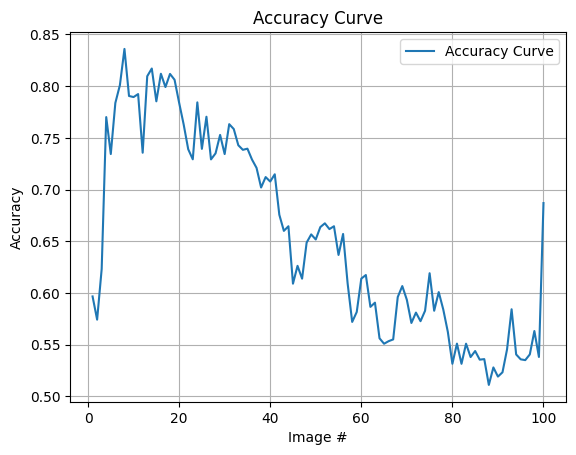

In [153]:
images = list(range(1, 101))  # 10 epochs
np.save(os.path.join("../", DIR, SAMPLING, EXP_NAME, EXP_NAME+"_accuracy_curve.npy"), accuracy_curve)
plt.figure()
# Plot
plt.plot(images, accuracy_curve, label='Accuracy Curve')
plt.xlabel('Image #')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("../", DIR, SAMPLING, EXP_NAME, "accuracy_curve.png"))
plt.show()

In [148]:
accuracy_avg = np.load('..\logs\TopDown\STD_ENTROPY_0.03_CM\STD_ENTROPY_0.03_CM_accuracy_curve.npy')
np.mean(accuracy_avg)

0.792016603124342